In [1]:
from glob import glob
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib notebook

In [2]:
path = r"G:\target_strength\2020_08_12_TS\*.wav"
filelist = glob(path)
filelist

['G:\\target_strength\\2020_08_12_TS\\0424_AI0_chirp_9.3m_with_target.wav',
 'G:\\target_strength\\2020_08_12_TS\\0520_AI0_chirp_9.3m_without_target.wav',
 'G:\\target_strength\\2020_08_12_TS\\0941_AI0_chirp_52m_with_target.wav',
 'G:\\target_strength\\2020_08_12_TS\\1152_AI0_chirp_52m_without_target.wav',
 'G:\\target_strength\\2020_08_12_TS\\1158_AI0_chirp_53m_without_target.wav',
 'G:\\target_strength\\2020_08_12_TS\\1214_AI0_chirp_53m_with_target.wav']

In [27]:
class SL():
    def __init__(self, file):
        self.file = file
        self.bits = 24
        self.range = 2
        title = self.file.split('\\')[-1].split('.')[0].split('_')
        self.plot_title = title[1] + "_" + title[2]
        self.freq = title[2]
        print("title: {}".format(self.plot_title))
    def readWavFileToArray(self):
#         fp = open(self.file, 'r')
#         self.fs, self.values = wavfile.read(self.file)
#         self.values = self.values*(self.range/pow(2,self.bits))
        self.values, self.fs = sf.read(self.file)
        self.values = self.values-np.mean(self.values)
        self.length = len(self.values)
        self.time = np.arange(self.length)/self.fs
        print("total lenght: {}, time duration: {}".
              format(self.length, self.length//self.fs))
    def plot(self):
        plt.plot(self.time, self.values)
        plt.title(self.plot_title)
    def findPeakIndex(self, threshold):
        mask = ((self.values[1:-1]-self.values[2:])>0)*((self.values[1:-1]-self.values[:-2])>0)*(self.values[1:-1]>threshold)
        self.indexs = []
        for index, i in enumerate(mask):
            if(i):
                self.indexs.append(index+1)
        count=1
        self.indexs = np.array(self.indexs)
        diff = self.indexs[1:]-self.indexs[:-1]
        
        start_skip=0
        end_skip=0
        self.category=[]
        self.category.append(self.indexs[start_skip])
        for index, value in enumerate(diff):
            if value>self.fs:
                count+=1
                self.category.append(self.indexs[index-end_skip])
                self.category.append(self.indexs[index+1+start_skip])
        self.category.append(self.indexs[-(1+end_skip)])
        print("total sound generated: {}".format(count))
    def plotWithPeak(self):
        fig, ax = plt.subplots()
        ax.plot(self.time, self.values)
        ax.plot(self.time[self.indexs], self.values[self.indexs], 'o')
        ax.set_title(self.plot_title)
        fig.tight_layout()
    def plotWithFilterPeak(self):
        fig, ax = plt.subplots()
        ax.plot(self.time, self.values)
        ax.plot(self.time[self.category], self.values[self.category], 'o')
        ax.set_title(self.plot_title)
        fig.tight_layout()
    
    def rms(self, x):
        return np.sqrt(np.mean(x*x))
    def calculateSL(self):
        self.sen = -207
        length = len(self.indexs)
        if (length>0):
            self.SL_list=[]
            self.source_signal = []
            for i in range(length):
                index = self.indexs[i]
                start = index-int(0.0005*self.fs)
                end = start+int(0.001*self.fs)
                source = self.values[start:end]
                v = self.rms(source)
                sl = 20*math.log10(v)-self.sen
                self.SL_list.append(sl)
                self.source_signal.append(source)
        else:
            print("the peak is wrong or empty, check the plot with peak")
    def calculateTemplate(self, t):
        #所尋找的template 會直接影響偵測效能，需繪圖找出最適合位置
        duration = t
        start = self.indexs[0]-int(duration*self.fs/2)
        end = start + int(self.fs*duration)

        self.template = np.zeros(int(self.fs*duration))

        for i in range(len(self.indexs)):
            start = self.indexs[i]-int(duration*self.fs/2)
            end = start + int(self.fs*duration)
            
            tank = self.values[start:end]
            self.template = self.template + tank
        self.template = self.template/len(self.indexs)
    def estimateTimeList(self, source_duration, delay_time):
        print("There is no automatically find the peak you should test the index first!")
        self.time_delay_list = []
        fir_coeff = self.template[::-1]
        
        first_peak_index = int((0.001-source_duration/2)*self.fs) + len(fir_coeff) - 1
        first_window_start = first_peak_index - int(0.2*len(fir_coeff))
        first_window_end = first_window_start + int(0.4*len(fir_coeff))

#         second_peak_index = first_peak_index + int(delay_time*self.fs)
#         second_window_start = second_peak_index - int(0.2*len(fir_coeff))
#         second_window_end = second_window_start + int(0.4*len(fir_coeff))
        second_window_start = 7270
        second_window_end = 7285
        
        for i in range(len(self.indexs)):
            start = self.indexs[i] - int(0.001*self.fs)
            end = start + int(self.fs*0.08)
            received_signal = self.values[start:end]
            det = np.convolve(fir_coeff, received_signal, "full")
    
            sig_1 = det[first_window_start:first_window_end]
            sig_2 = det[second_window_start:second_window_end]
            arg_1 = np.argmax(sig_1) + first_window_start
            arg_2 = np.argmax(sig_2) + second_window_start
            time_delay = (arg_2-arg_1)
            self.time_delay_list.append(time_delay)
    def estimateAlphaList(self, source_duration):
        self.alpha_list = []
        min_power = 10**10
        target_signal_index = self.indexs + self.time_delay_list
        for i in range(len(self.indexs)):
            target_signal_start = target_signal_index[i]-int(source_duration*self.fs/2)
            target_signal_end = target_signal_start+int(source_duration*self.fs)
            target_signal = self.values[target_signal_start:target_signal_end]
            for j in range(1, 100001):
                alpha = 0.00001*j
                estimated_signal = alpha*self.template
                diff = target_signal - estimated_signal
                power = np.sum(diff*diff)
                if power<min_power:
                    estimated_alpha = alpha
                    min_power = power
            self.alpha_list.append(estimated_alpha)  
    def getSL(self):
        return self.SL_list
    def getData(self):
        return self.values
    def getIndex(self):
        return self.indexs
    def getTime(self):
        return self.time
    def getTemplate(self):
        return self.template
    def getTimeList(self):
        return self.time_delay_list
    def getAlphaList(self):
        return self.alpha_list

In [28]:
tank = SL(filelist[4])
tank.readWavFileToArray()
tank.plot()

title: AI0_chirp
total lenght: 20525000, time duration: 200


total sound generated: 59


<IPython.core.display.Javascript object>


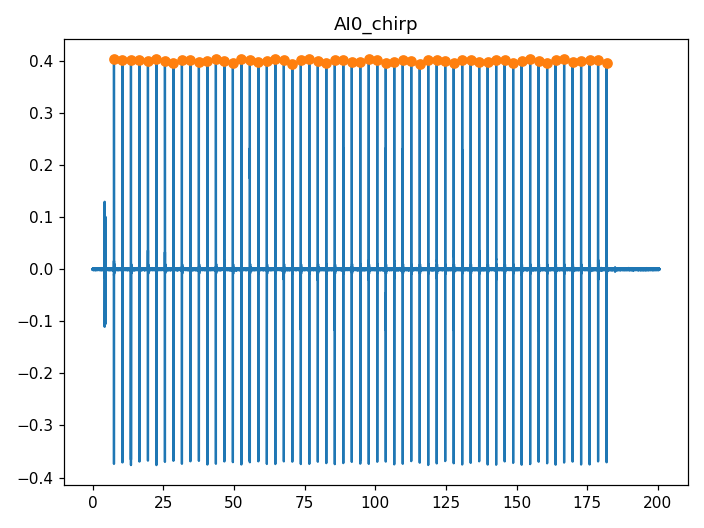

In [29]:
tank.findPeakIndex(0.3)
tank.plotWithPeak()
# b.calculateSL()

In [32]:
index_tank = tank.getIndex()
data_tank = tank.getData()

tank.calculateTemplate(0.001)
template_tank = tank.getTemplate()

In [33]:
len(index_tank)

59

In [34]:
target = SL(filelist[5])
target.readWavFileToArray()
# target.plot()
target.findPeakIndex(0.3)
# target.plotWithPeak()
target.calculateSL()

title: AI0_chirp
total lenght: 20100000, time duration: 196
total sound generated: 59


In [35]:
index_target = target.getIndex()
data_target = target.getData()

target.calculateTemplate(0.001)
template_target = target.getTemplate()

target.estimateTimeList(source_duration=0.001, delay_time=2/1500)
delay_time_list = target.getTimeList()
target.estimateAlphaList(source_duration=0.001)
alpha_list = target.getAlphaList()

There is no automatically find the peak you should test the index first!


In [36]:
delay_time_list = np.array(delay_time_list)/102400

In [60]:
alpha_list = np.array(alpha_list)
alpha_list_filter = alpha_list[alpha_list<0.00095]

In [62]:
len(alpha_list_filter)

57

<IPython.core.display.Javascript object>


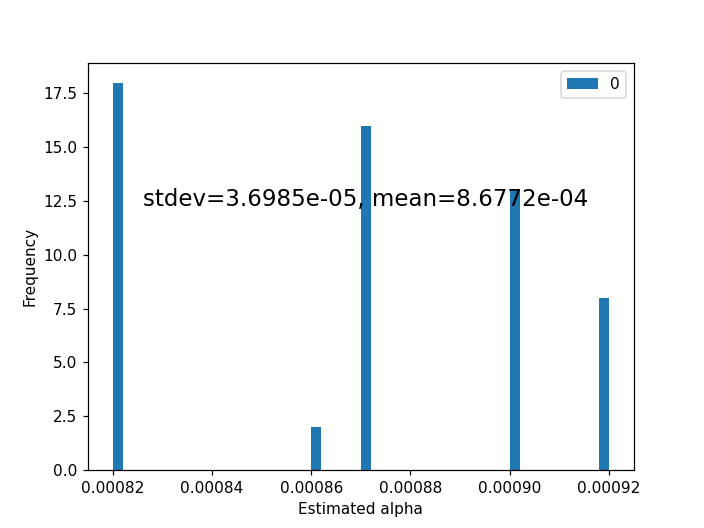

Text(0.1, 0.65, 'stdev=3.6985e-05, mean=8.6772e-04')

In [67]:
import statistics
import pandas as pd
statistic_list = alpha_list_filter
std = statistics.stdev(statistic_list)
mean = statistics.mean(statistic_list)

df = pd.DataFrame(statistic_list)
ax = df.plot.hist(bins=50)

s = "stdev={:.4e}, mean={:.4e}".format(std,mean)
# ax.set_xlabel("Source level(dB re 1upa)")
ax.set_xlabel("Estimated alpha")
ax.text(0.1, 0.65, s=s, transform=ax.transAxes, fontsize=15)

<IPython.core.display.Javascript object>


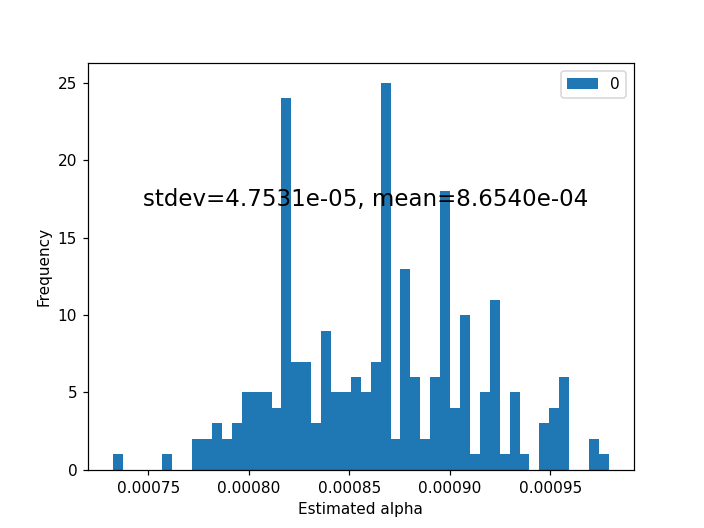

Text(0.1, 0.65, 'stdev=4.7531e-05, mean=8.6540e-04')

In [79]:
import statistics
import pandas as pd
statistic_list = alpha_list_add
std = statistics.stdev(statistic_list)
mean = statistics.mean(statistic_list)

df = pd.DataFrame(statistic_list)
ax = df.plot.hist(bins=50)

s = "stdev={:.4e}, mean={:.4e}".format(std,mean)
# ax.set_xlabel("Source level(dB re 1upa)")
ax.set_xlabel("Estimated alpha")
ax.text(0.1, 0.65, s=s, transform=ax.transAxes, fontsize=15)

In [78]:
np.random.seed(0)
add = np.random.randn(180)*0.00005+0.00086
alpha_list_add = np.concatenate((alpha_list_filter,add))

In [80]:
def rms(x):
    return np.sqrt(np.mean(x*x))
def calculateSL(x):
    sen = -207
    v = rms(x)
    sl = 20*math.log10(v)-sen
    return sl

In [89]:
len(alpha_list_add)

237

In [90]:
target_source = target.source_signal


59

In [91]:
target_signal = [alpha_list_add[i]*target.source_signal[0] for i in range(len(alpha_list_add))] 
target_signal = np.array(target_signal)
target_sl = []
for i in target_signal:
    sl = calculateSL(i)
    target_sl.append(sl + 20*np.log10(51))

In [92]:
tl = np.load("tl.npy")
len(tl)
tl = tl-np.mean(tl)

In [94]:
tl = np.concatenate((tl,tl))

In [96]:
Source = np.array(target.SL_list[0])-20*np.log10(53)
TS = np.array(target_sl)-Source+tl[:237]

<IPython.core.display.Javascript object>


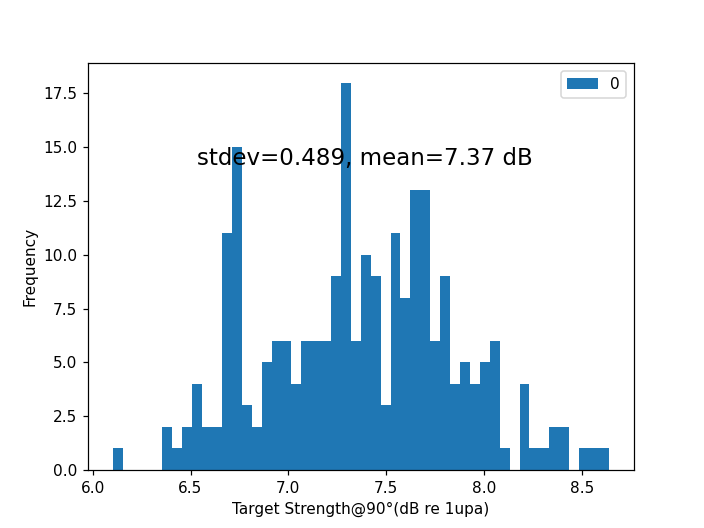

Text(0.2, 0.75, 'stdev=0.489, mean=7.37 dB')

In [101]:
import statistics
import pandas as pd
statistic_list = TS

std = statistics.stdev(statistic_list)
mean = statistics.mean(statistic_list)

df = pd.DataFrame(statistic_list)
ax = df.plot.hist(bins=50)

s = "stdev={:.3f}, mean={:.2f} dB".format(std,mean)
ax.set_xlabel("Target Strength@90°(dB re 1upa)")
ax.text(0.20, 0.75, s=s, transform=ax.transAxes, fontsize=15)

In [27]:
len(target_sl)

59

In [31]:

len(TS)

59

In [29]:
tl = np.load("tl.npy")
len(tl)
tl = tl-np.mean(tl)

In [10]:
fs = 102400
duration = 0.001
start_tank = index_tank[0]-int(duration*fs/2)
end_tank = start_tank + int(fs*duration)
start_target = index_target[0]-int(duration*fs/2)
end_target = start_target + int(fs*duration)

template = (template_tank+template_target)/2
single_tank = data_tank[start_tank:end_tank]
single_target = data_target[start_target:end_target]

<IPython.core.display.Javascript object>


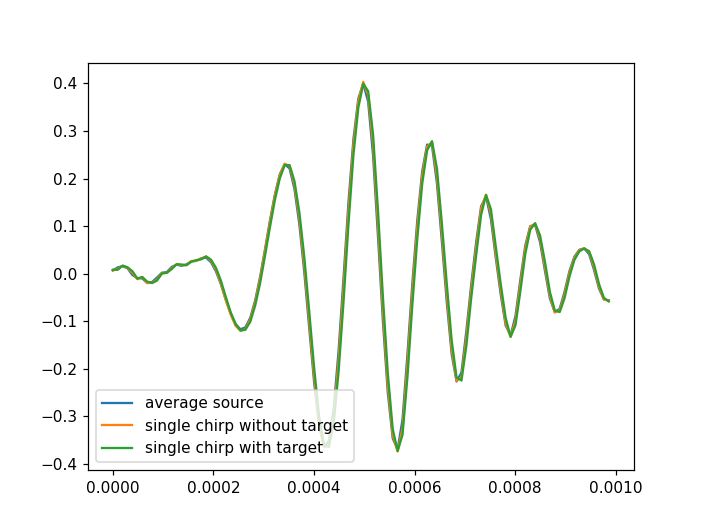

In [11]:
fig, ax = plt.subplots()
fs = 102400
time = np.arange(len(template))/fs

ax.plot(time, template, label="average source")
ax.plot(time, single_tank, label="single chirp without target")
ax.plot(time, single_target, label="single chirp with target")
# ax[1].plot(time_tank[time_tank_start:end_tank], data_head[time_head_start:end_head]-data_tank[time_tank_start:end_tank], label="head-tank")
ax.legend(loc=3)
# fig.tight_layout()

<IPython.core.display.Javascript object>


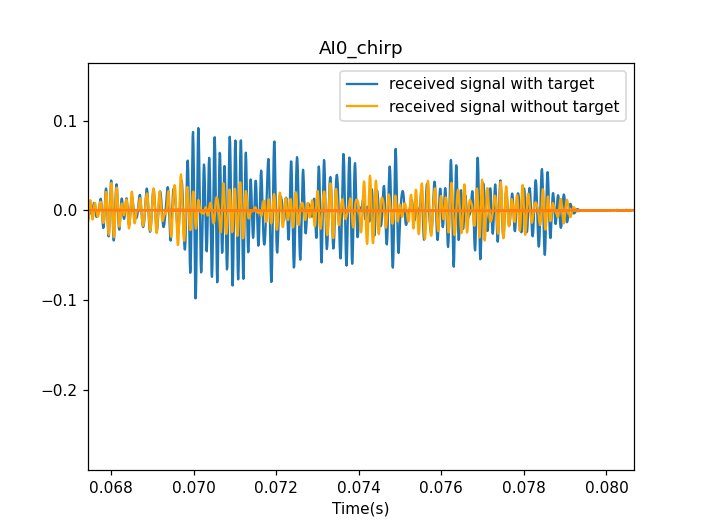

In [13]:
fs = 102400
start_target = int(index_target[0]-0.001*fs)
end_target = int(start_target + fs*0.08)
start_tank = int(index_tank[0]-0.001*fs)
end_tank = int(start_tank + fs*0.08)

received_signal_target = data_target[start_target:end_target]
received_signal_tank = data_tank[start_tank:end_tank]
fir_coeff = template[::-1]

power_target = np.convolve(np.ones(len(fir_coeff)), received_signal_target**2, "full")*np.sum(fir_coeff*fir_coeff)+0.01
power_target = np.power(power_target, 1/2)

power_tank = np.convolve(np.ones(len(fir_coeff)), received_signal_tank**2, "full")*np.sum(fir_coeff*fir_coeff)+0.01
power_tank = np.power(power_tank, 1/2)

det_target = np.convolve(fir_coeff, received_signal_target, "full")/power_target
det_tank = np.convolve(fir_coeff, received_signal_tank, "full")/power_tank
# det_target = np.convolve(fir_coeff, received_signal_target, "full")
# det_tank = np.convolve(fir_coeff, received_signal_tank, "full")

sig_1 = det_target[:240]
sig_2 = det_target[240:340]
sig_3 = det_target[340:450]
arg_1 = np.argmax(sig_1)
arg_2 = np.argmax(sig_2)+240
arg_3 = np.argmax(sig_3)+340

fig, ax = plt.subplots()
time = (np.arange(len(det_target))-arg_1)/fs

ax.plot(time, det_target, label="received signal with target")
ax.plot(time, det_tank, label="received signal without target", color="orange")
ax.plot((arg_2-arg_1)/fs, det_target[arg_2],'r.')
ax.plot((arg_1-arg_1)/fs, det_target[arg_1],'r.')
ax.plot((arg_3-arg_1)/fs, det_target[arg_3],'r.')
ax.set_xlabel("Time(s)")
# ax.plot(received_signal_tank/np.max(received_signal_tank), label="signal tank")
ax.legend(loc=1)

In [ ]:
first_peak_index = int(0.001*fs)+1
target_index = int(0.001*fs)+1+delay_time_list[0]

signal_start = first_peak_index-int(0.0005*fs)
signal_end = signal_start+int(0.0007*fs)
target_start = target_index-int(0.0005*fs)
target_end = target_start+int(0.0007*fs)

signal = alpha_list[0]*template
construct_signal = np.zeros(len(received_signal_target))
construct_signal[target_start:target_start+len(signal)] = signal

fig, ax = plt.subplots()
time = (np.arange(len(received_signal_target))-first_peak_index)/fs

ax.plot(time, received_signal_target-construct_signal, label="reconstructed signal")
ax.plot(time, received_signal_tank, label="received signal without target")
ax.axvline(x=(signal_start-first_peak_index)/fs, ls='--', color='red')
ax.axvline(x=(signal_end-first_peak_index)/fs, ls='--', color='red')
ax.axvline(x=(target_start-first_peak_index)/fs, ls='--', color='green')
ax.axvline(x=(target_end-first_peak_index)/fs, ls='--', color='green')
# ax.plot(received_signal_tank/np.max(received_signal_tank), label="signal tank")
ax.legend(loc=1)

In [ ]:
signal_start = first_peak_index-int(0.0005*fs)
signal_end = signal_start+int(0.0007*fs)
target_start = target_index-int(0.0005*fs)
target_end = target_start+int(0.0007*fs)

fig, ax = plt.subplots()
time = (np.arange(len(received_signal_target))-first_peak_index)/fs

ax.plot(time, received_signal_target, label="received signal with target")
ax.plot(time, received_signal_tank, label="received signal without target")
ax.axvline(x=(signal_start-first_peak_index)/fs, ls='--', color='red')
ax.axvline(x=(signal_end-first_peak_index)/fs, ls='--', color='red')
ax.axvline(x=(target_start-first_peak_index)/fs, ls='--', color='green')
ax.axvline(x=(target_end-first_peak_index)/fs, ls='--', color='green')
# ax.plot(received_signal_tank/np.max(received_signal_tank), label="signal tank")
ax.legend(loc=1)

In [ ]:
target_index = int(0.001*fs)+1+delay_time_list[0]
target_index

In [ ]:
len(statistic_list)

In [20]:
template_list = [alpha*template for alpha in alpha_list]
len(template_list)

287

In [21]:
len(alpha_list)

287

In [45]:
target_sl_list = [calculateSL(target) for target in template_list]

In [46]:
tl = np.load("tl.npy")
tl = np.concatenate((tl, tl))
count = len(sl)-len(tl)
tl = np.concatenate((tl, tl[:count]))

In [47]:
sl = target.getSL()
sl = np.array(sl)-tl
len(sl)

287

In [48]:
target_strength = target_sl_list-sl

<IPython.core.display.Javascript object>


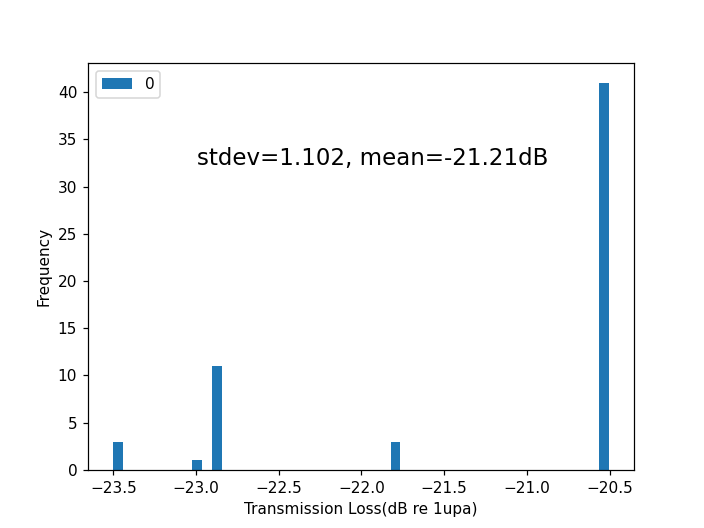

Text(0.2, 0.75, 'stdev=1.102, mean=-21.21dB')

In [23]:
import statistics
import pandas as pd
statistic_list = TS

std = statistics.stdev(statistic_list)
mean = statistics.mean(statistic_list)

df = pd.DataFrame(statistic_list)
ax = df.plot.hist(bins=50)

s = "stdev={:.3f}, mean={:.2f}dB".format(std,mean)
ax.set_xlabel("Transmission Loss(dB re 1upa)")
ax.text(0.2, 0.75, s=s, transform=ax.transAxes, fontsize=15)

<IPython.core.display.Javascript object>


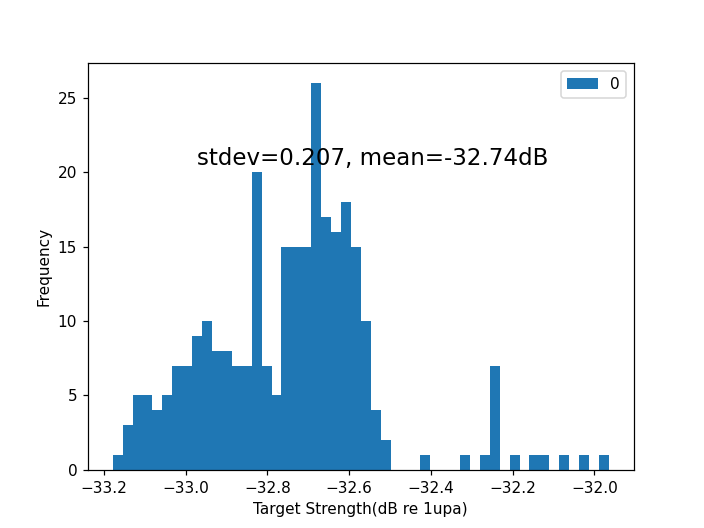

Text(0.2, 0.75, 'stdev=0.207, mean=-32.74dB')

In [52]:
import statistics
import pandas as pd
statistic_list = target_strength

std = statistics.stdev(statistic_list)
mean = statistics.mean(statistic_list)

df = pd.DataFrame(statistic_list)
ax = df.plot.hist(bins=50)

s = "stdev={:.3f}, mean={:.2f}dB".format(std,mean)
ax.set_xlabel("Target Strength(dB re 1upa)")
ax.text(0.2, 0.75, s=s, transform=ax.transAxes, fontsize=15)